In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
from cv2 import fastNlMeansDenoising
from itertools import permutations
from os.path import join, isdir
from os import listdir
from glob import glob
import pickle

from keras import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, LeakyReLU
from keras.losses import binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


## Model

In [2]:
def build_model(size, start_neurons=8):
    input_layer = Input(size + (1,))
    
    conv1 = Conv2D(start_neurons*1,(3,3), padding="same")(input_layer)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    conv1 = Conv2D(start_neurons*1,(3,3), padding="same")(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3), padding="same")(pool1)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    conv2 = Conv2D(start_neurons*2,(3,3), padding="same")(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), padding="same")(pool2)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(start_neurons*4,(3,3), padding="same")(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3), padding="same")(pool3)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(start_neurons*8,(3,3), padding="same")(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    conv5 = Conv2D(start_neurons*16,(3,3), padding="same")(pool4)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(start_neurons*16,(3,3), padding="same")(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    pool5 = Dropout(0.5)(pool5)

    # Middle
    convm = Conv2D(start_neurons*32,(3,3), padding="same")(pool5)
    convm = LeakyReLU(alpha=0.1)(convm)
    convm = Conv2D(start_neurons*32,(3,3), padding="same")(convm)
    convm = LeakyReLU(alpha=0.1)(convm)

    deconv5 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(0.5)(uconv5)
    uconv5 = Conv2D(start_neurons*16,(3,3), padding="same")(uconv5)
    uconv5 = LeakyReLU(alpha=0.1)(uconv5)
    uconv5 = Conv2D(start_neurons*16,(3,3), padding="same")(uconv5)
    uconv5 = LeakyReLU(alpha=0.1)(uconv5)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3), padding="same")(uconv4)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3), padding="same")(uconv4)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3), padding="same")(uconv3)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3), padding="same")(uconv3)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3), padding="same")(uconv2)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3), padding="same")(uconv2)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3), padding="same")(uconv1)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3), padding="same")(uconv1)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(input_layer, output_layer)
    return model

In [3]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))/K.log(10.0)

get_custom_objects().update({'PSNR': PSNR})

In [4]:
def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

get_custom_objects().update({'SSIM': SSIM})

In [5]:
def MSE(img1, img2):
    shape = np.array(img1.shape).prod()
    res = ((img1-img2)**2).sum()/shape
    if (res == 0):
        raise ValueError
    else:
        return res

def compute_psnr(img_pred, img_gt):
    img_pred = img_pred.astype('float64')
    img_gt = img_gt.astype('float64')
    max_pixel = 1.0
    return 10*np.log10(max_pixel**2/MSE(img_pred, img_gt))

## Data

In [6]:
data_dir = 'data/spectra/images'
dirs = listdir(data_dir)

In [7]:
def datagen(pairs, size, batch_size):
    x = np.empty((batch_size,)+size)
    y = np.empty((batch_size,)+size)

    batch_ind = 0
    epoch_ind = 0
    n_samples = len(pairs)

    while True:
        train_img = imread(pairs[epoch_ind][0], as_gray=True)
        target_img = imread(pairs[epoch_ind][1], as_gray=True)

        x[batch_ind] = resize(train_img, size)
        y[batch_ind] = resize(target_img, size)

        batch_ind += 1
        epoch_ind += 1

        if batch_ind == batch_size:
            batch_ind = 0
            yield x.reshape(x.shape+(1,)), y.reshape(y.shape+(1,))

        if epoch_ind == n_samples:
            epoch_ind = 0

In [8]:
def get_images(data_dir, size, n=4):
    files = glob(join(data_dir, '*png')) 
    n = min(n, len(files))
    x = np.empty((n,)+size)
    for i,file in enumerate(files[:n]):
        x[i] = resize(imread(file, as_gray=True), size)
        
    return x.reshape(x.shape+(1,))

## Test

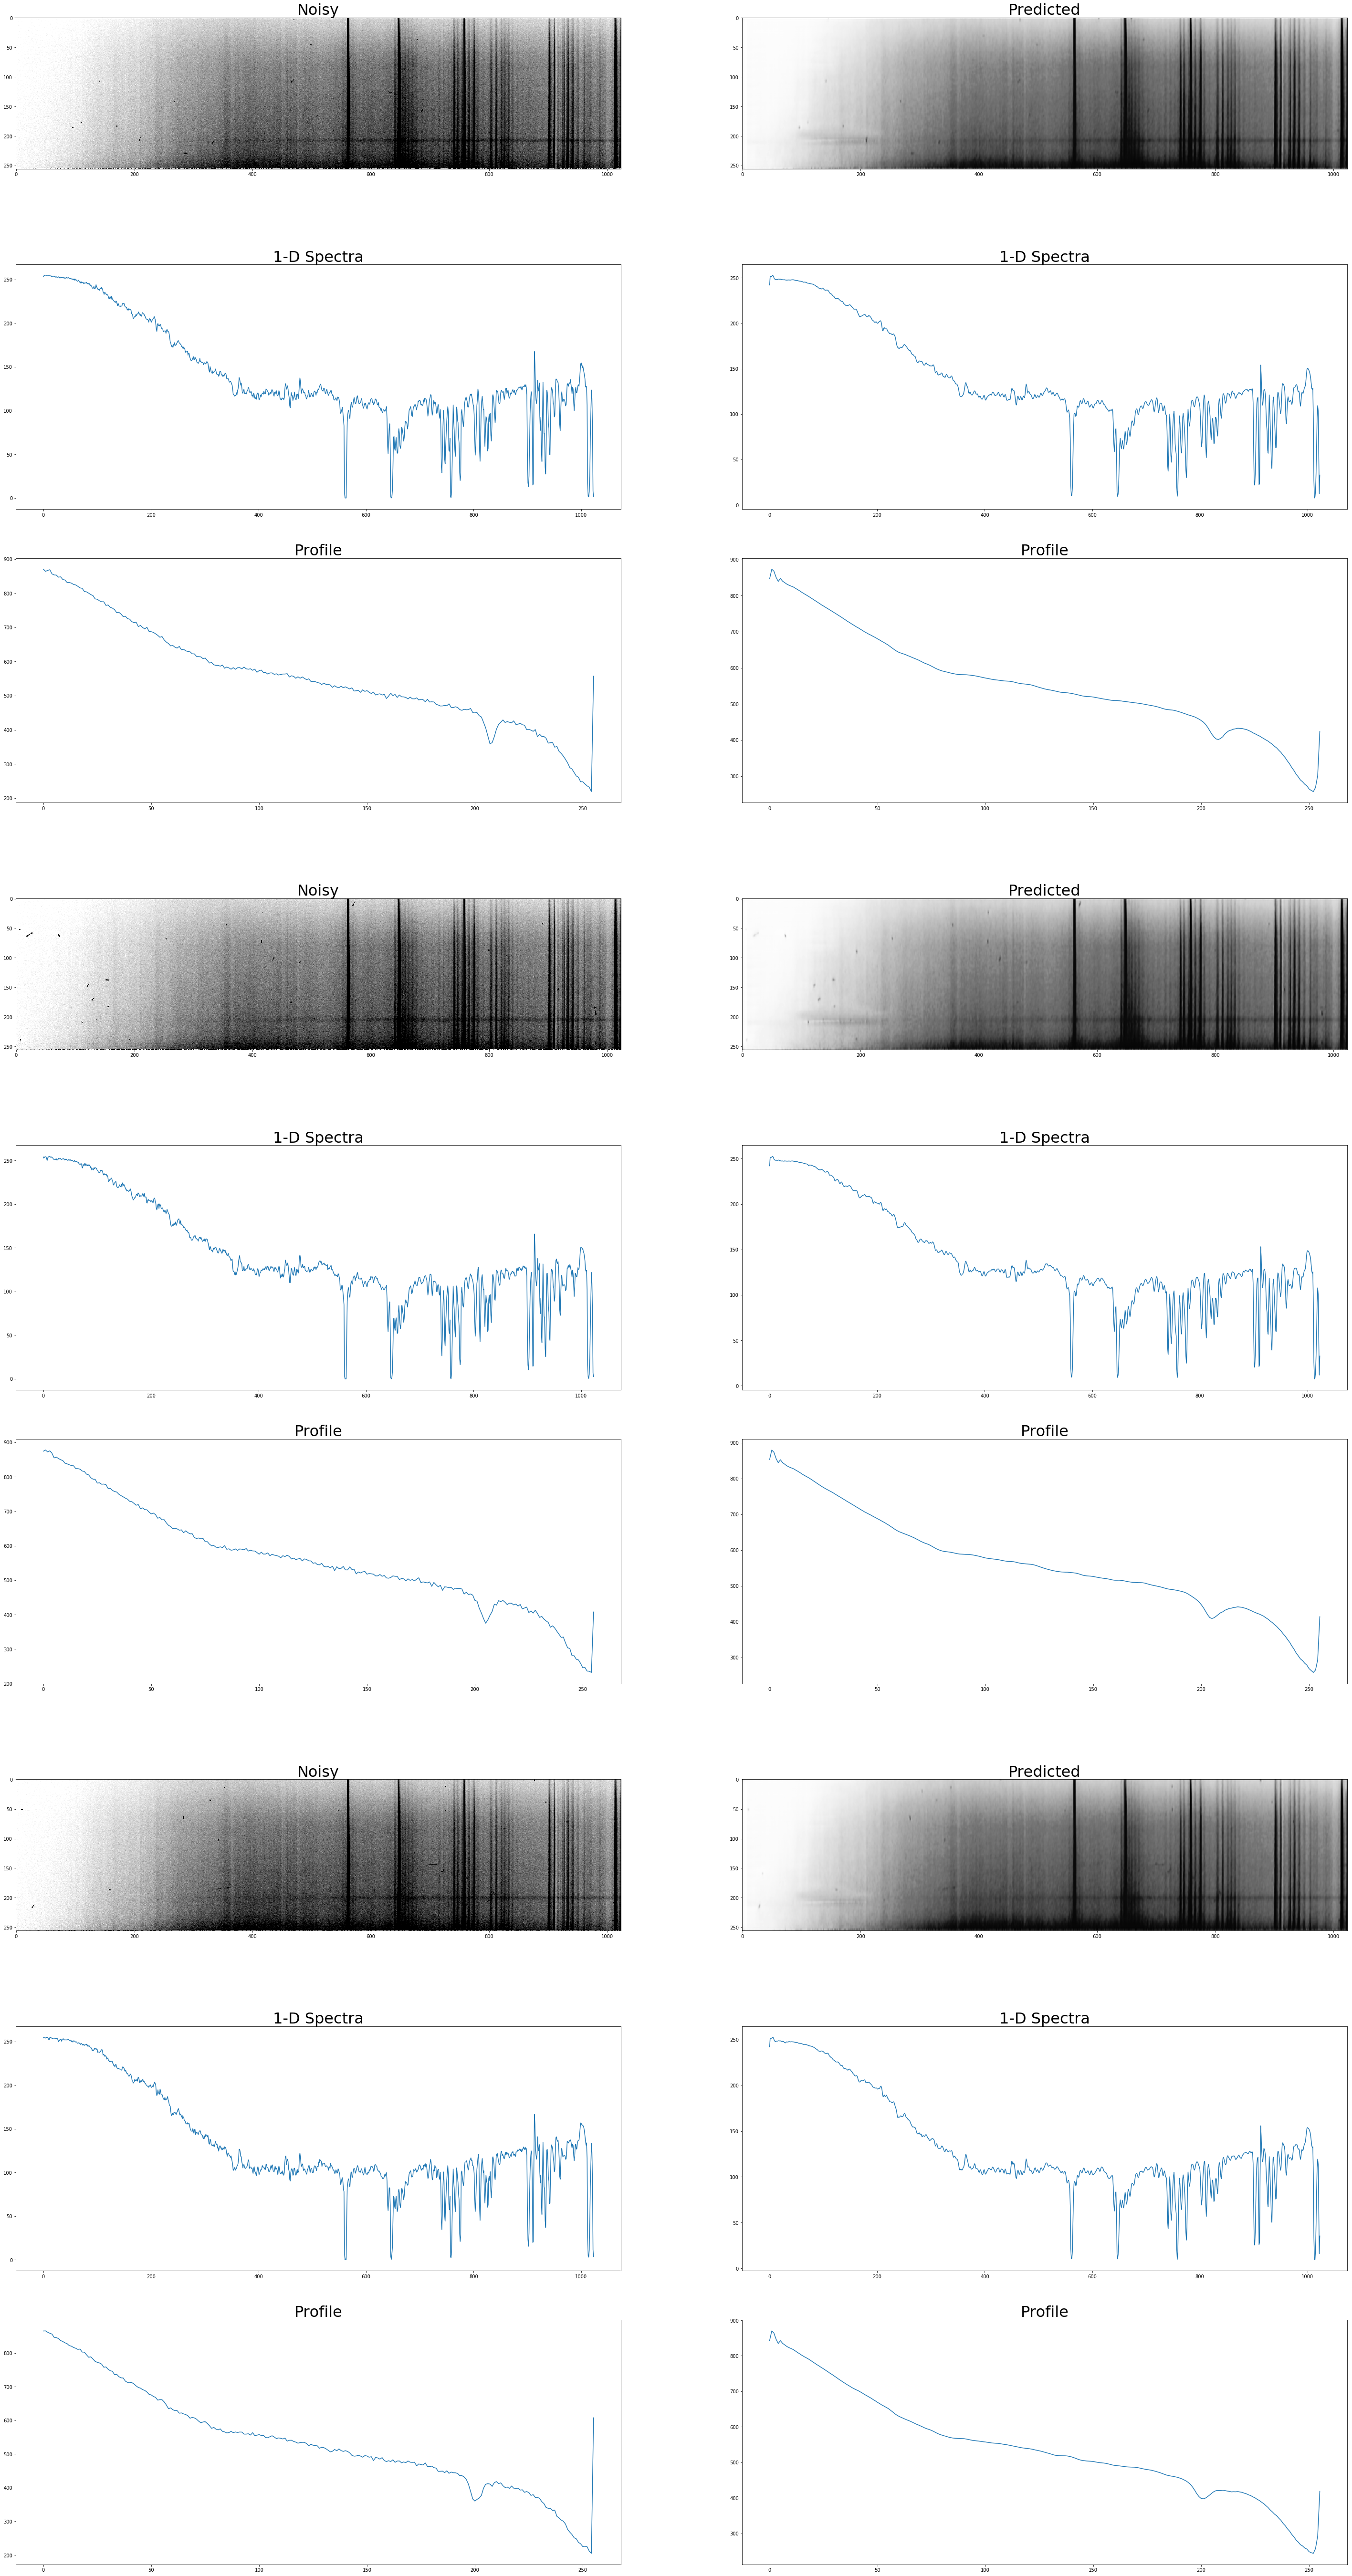

In [62]:
size = (256,1024)

model = build_model(size)
model.compile(loss='mse', optimizer=Adam(), metrics=['PSNR', 'SSIM'])
model.load_weights('models/model_spectra_noise_removing.hdf5')

n = 3
imgs = get_images(join(data_dir, dirs[0]), size, n)
preds = model.predict(imgs)

fig, axes = plt.subplots(3*n, 2, figsize=(50,100))
for j,i in enumerate(range(0, 3*n, 3)):
    noisy_img = imgs[j].reshape(size)
    pred_img = preds[j].reshape(size)
    
    axes[i,0].imshow(noisy_img, cmap='gray')
    axes[i,0].set_title("Noisy", {'fontsize': 32})
    
    axes[i+1,0].plot(noisy_img.sum(axis=0))
    axes[i+1,0].set_title('1-D Spectra', {'fontsize': 32})
    
    axes[i+2,0].plot(noisy_img.sum(axis=1))
    axes[i+2,0].set_title('Profile', {'fontsize': 32})
    
    axes[i,1].imshow(pred_img, cmap='gray')
    axes[i,1].set_title("Predicted", {'fontsize': 32})
    
    axes[i+1,1].plot(pred_img.sum(axis=0))
    axes[i+1,1].set_title('1-D Spectra', {'fontsize': 32})
    
    axes[i+2,1].plot(pred_img.sum(axis=1))
    axes[i+2,1].set_title('Profile', {'fontsize': 32})

Text(0, 0.5, 'PSNR')

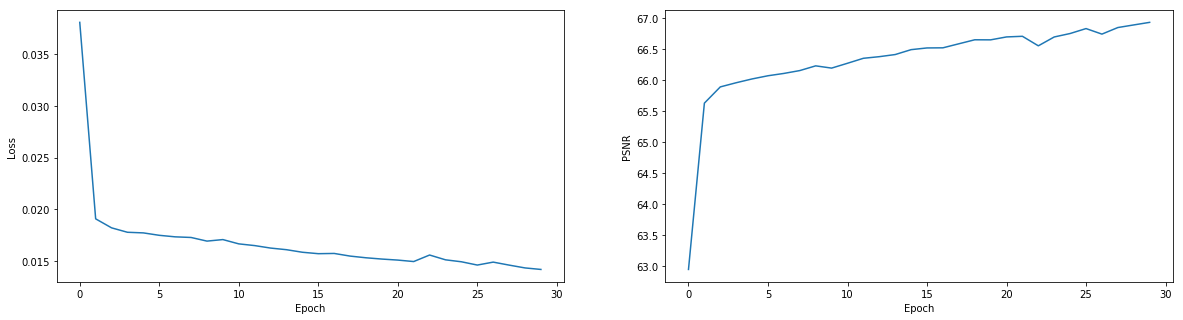

In [54]:
with open('stats/model_spectra_noise_removing.pickle', 'rb') as f:
    stats = pickle.load(f)
    
_, axes = plt.subplots(1, 2, figsize=(20,5))

axes[0,].plot(stats['loss'])
axes[0,].set_xlabel("Epoch")
axes[0,].set_ylabel("Loss")

axes[1,].plot(stats['PSNR'])
axes[1,].set_xlabel("Epoch")
axes[1,].set_ylabel("PSNR")